<a href="https://colab.research.google.com/github/erikrozi/acmlab/blob/main/unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in the Shared Google Drive
FOLDERNAME = 'Shared drives/Unsupervised'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/{}'.format(FOLDERNAME))

# !pwd
%cd /content/drive/$FOLDERNAME/
# %cp -vR * /content
# %cd /content
# !pwd
# !unzip imagery.zip -d imagery
# !unzip test_imagery.zip -d test_imagery
# %ls -lh

Mounted at /content/drive
/content/drive/Shared drives/Unsupervised


In [ ]:
 #!unzip imagery.zip -d imagery
 #!unzip test_imagery.zip -d test_imagery

# drive.flush_and_unmount()
# drive.mount('/content/drive', force_remount=True)

Archive:  imagery.zip
replace imagery/14_2794_6528.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace imagery/14_2794_6529.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace imagery/14_2794_6530.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test_imagery.zip
replace test_imagery/14_2614_6316.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# Importing the standard ML libraries...
%load_ext autoreload
%autoreload 2

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices

import torch
import torchvision                      # for MNIST dataset/working with images

import math

# take advantage of GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load Census Data

In [92]:
# Loads data with zip and aveincome
tax_returns_data = pd.read_csv("16zpallnoagi.csv")
cleaned_tax_data = pd.DataFrame(tax_returns_data, columns = ["ZIPCODE", "N1", "A02650"])
cleaned_tax_data = cleaned_tax_data[(cleaned_tax_data['ZIPCODE'] <= 97000) & (cleaned_tax_data['ZIPCODE'] >= 90000)] #remove zipcodes not in california
cleaned_tax_data.columns = ['zip', 'N1', 'A02650']
cleaned_tax_data['aveincome'] = ((cleaned_tax_data['A02650'] / cleaned_tax_data['N1']))#.astype(np.int32)

In [93]:
# Loads zips for Los Angeles
ziplation_data = pd.read_csv("ziplatlon.csv", sep = ";")
parsed_ziplation_data = ziplation_data[(ziplation_data['latitude'] <= 34.3) & (ziplation_data['latitude'] >= 33.5) & (ziplation_data['longitude'] >= -118.6) & (ziplation_data['longitude'] <= -117.6)]
parsed_ziplation_data = pd.merge(parsed_ziplation_data, cleaned_tax_data, how='left', on= 'zip')
parsed_ziplation_data = parsed_ziplation_data.dropna()

In [94]:
import util as util
import webmercator as webmercator

In [95]:
# creates image data and pulls latitude and longitude
z = 14
pos = np.empty([1980, 5])
for x in range(2794, 2839):
  for y in range(6528, 6572):
    curPos = (x - 2794) * (6572 - 6528) + (y - 6528)
    pos[curPos, 0] = x
    pos[curPos, 1] = y
    pos[curPos, 2] = webmercator.lat(y, z)
    pos[curPos, 3] = webmercator.lon(x, z)
    pos[curPos, 4] = util.getElevation(pos[curPos, 2], pos[curPos, 3])
image_pos_data = pd.DataFrame({'x': pos[:,0].astype(int), 'y': pos[:,1].astype(int), 'z': 14, 'latitude': pos[:,2], 'longitude': pos[:,3], 'elevation': pos[:,4]})
image_pos_data['img'] = "14_" + image_pos_data['x'].astype(str) + "_" + image_pos_data['y'].astype(str) + ".jpg"

Maps image to closest zip code

In [96]:
def calc_distance(lat1, long1, lat2, long2):
  xdist = long1 - long2
  ydist = lat1 - lat2
  return math.sqrt(xdist**2 + ydist**2)

In [97]:
np_ziplation = parsed_ziplation_data.to_numpy()
tile_zips = np.empty([image_pos_data.shape[0], 1])

np_ziplation.shape

#very inefficient lol
#for each image tile, loops through all the possible zipcodes, and chooses the one with the smallest distance
for i in range(image_pos_data.shape[0]):
  min_dist = 100000 #just made this an arbitrarily large number cuz iwas lazy
  for j in range(np_ziplation.shape[0]):
    zip_coords = np_ziplation[j][7].split(",") #splitting geopoint coords into latitude and longitude
    pt = image_pos_data['latitude'][i]
    cur_dist = calc_distance(pt, image_pos_data['longitude'][i], float(zip_coords[0]), float(zip_coords[1]))
    if cur_dist < min_dist:
      min_dist = cur_dist
      tile_zips[i] = np_ziplation[j][0]
image_pos_data['zipcode'] = tile_zips.astype(np.int32)

In [98]:
# Gets rid of ocean tiles
image_pos_data = image_pos_data[~(image_pos_data['elevation'] == 0)]

In [99]:
image_income_data = pd.DataFrame(image_pos_data, columns = ['img', 'zipcode'])
image_income_data.columns = ['img', 'zip']
image_income_data = pd.merge(image_income_data, cleaned_tax_data, how='left', on='zip')
image_income_data

img    zip     N1   A02650   aveincome
0     14_2794_6528.jpg  91311  18560  1694366   91.291272
1     14_2794_6529.jpg  91311  18560  1694366   91.291272
2     14_2794_6530.jpg  91311  18560  1694366   91.291272
3     14_2794_6531.jpg  91311  18560  1694366   91.291272
4     14_2794_6532.jpg  91311  18560  1694366   91.291272
...                ...    ...    ...      ...         ...
1452  14_2838_6567.jpg  92692  23430  2676168  114.219718
1453  14_2838_6568.jpg  92694  11460  2027274  176.900000
1454  14_2838_6569.jpg  92694  11460  2027274  176.900000
1455  14_2838_6570.jpg  92694  11460  2027274  176.900000
1456  14_2838_6571.jpg  92675  16750  2172841  129.721851

[1457 rows x 5 columns]

In [100]:
# Remove the unnecessary columns beside image url & average income
image_income_data = image_income_data[['img', 'aveincome', 'zip']]
image_income_data

img   aveincome    zip
0     14_2794_6528.jpg   91.291272  91311
1     14_2794_6529.jpg   91.291272  91311
2     14_2794_6530.jpg   91.291272  91311
3     14_2794_6531.jpg   91.291272  91311
4     14_2794_6532.jpg   91.291272  91311
...                ...         ...    ...
1452  14_2838_6567.jpg  114.219718  92692
1453  14_2838_6568.jpg  176.900000  92694
1454  14_2838_6569.jpg  176.900000  92694
1455  14_2838_6570.jpg  176.900000  92694
1456  14_2838_6571.jpg  129.721851  92675

[1457 rows x 3 columns]

In [101]:
image_income_data.to_csv('image_income_data.csv')

# Load the imagery data


In [102]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class TileImageryDataset(Dataset):
  """Tile imagery dataset."""

  def __init__(self, csv_file, root_dir, transform=None):
    # Load into tensors
    self.annotations = pd.read_csv(csv_file)
    #self.annotations.iloc[:,2] = self.annotations.iloc[:, 2].astype('float32')
    self.root_dir = root_dir
    self.transform = transform

    # Perform data augmentation

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    image = Image.open(self.root_dir +  self.annotations.iloc[index,1])
    y_label = torch.tensor(self.annotations.iloc[index, 2])

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

  #def load_images():
  #  tensors = []
  #  for x in range(2794, 2839):
  #    for y in range(6528, 6572):
  #      image = Image.open(f"images/14_{x}_{y}.jpg").convert("RGB")
  #      # TODO change
  #      #jaden
  #      data = asarray(image) #convert to np array, could also do np.array(Image.open...)
  #      data = torch.from_numpy(data) #convert to tensor
  #      preprocess = transforms.Compose([
  #          transforms.Resize(256),
  #          transforms.CenterCrop(224),
  #          transforms.ToTensor(),
  #          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  #      ])
  #      input_tensor = preprocess(image)
  #      # tensory push thing?

In [103]:
from torch.utils.data import Dataset, DataLoader
batch_size = 32

transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(degrees = (90, 90)),
    transforms.ToTensor(),      
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                  
])

dataset = TileImageryDataset(csv_file = 'image_income_data.csv', root_dir = 'imagery/', transform = transformations)

train_set, test_set = torch.utils.data.random_split(dataset, [1200, 257])

trainloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle=True)
testloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle=False)



In [104]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32])


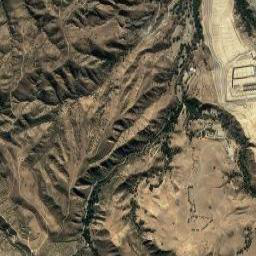

In [105]:
i = 0
image, label = dataset[i]
image = np.moveaxis(image.numpy(), 0, -1)
image = (image * 255).astype(np.uint8)
display(Image.fromarray(image).convert("RGB"))

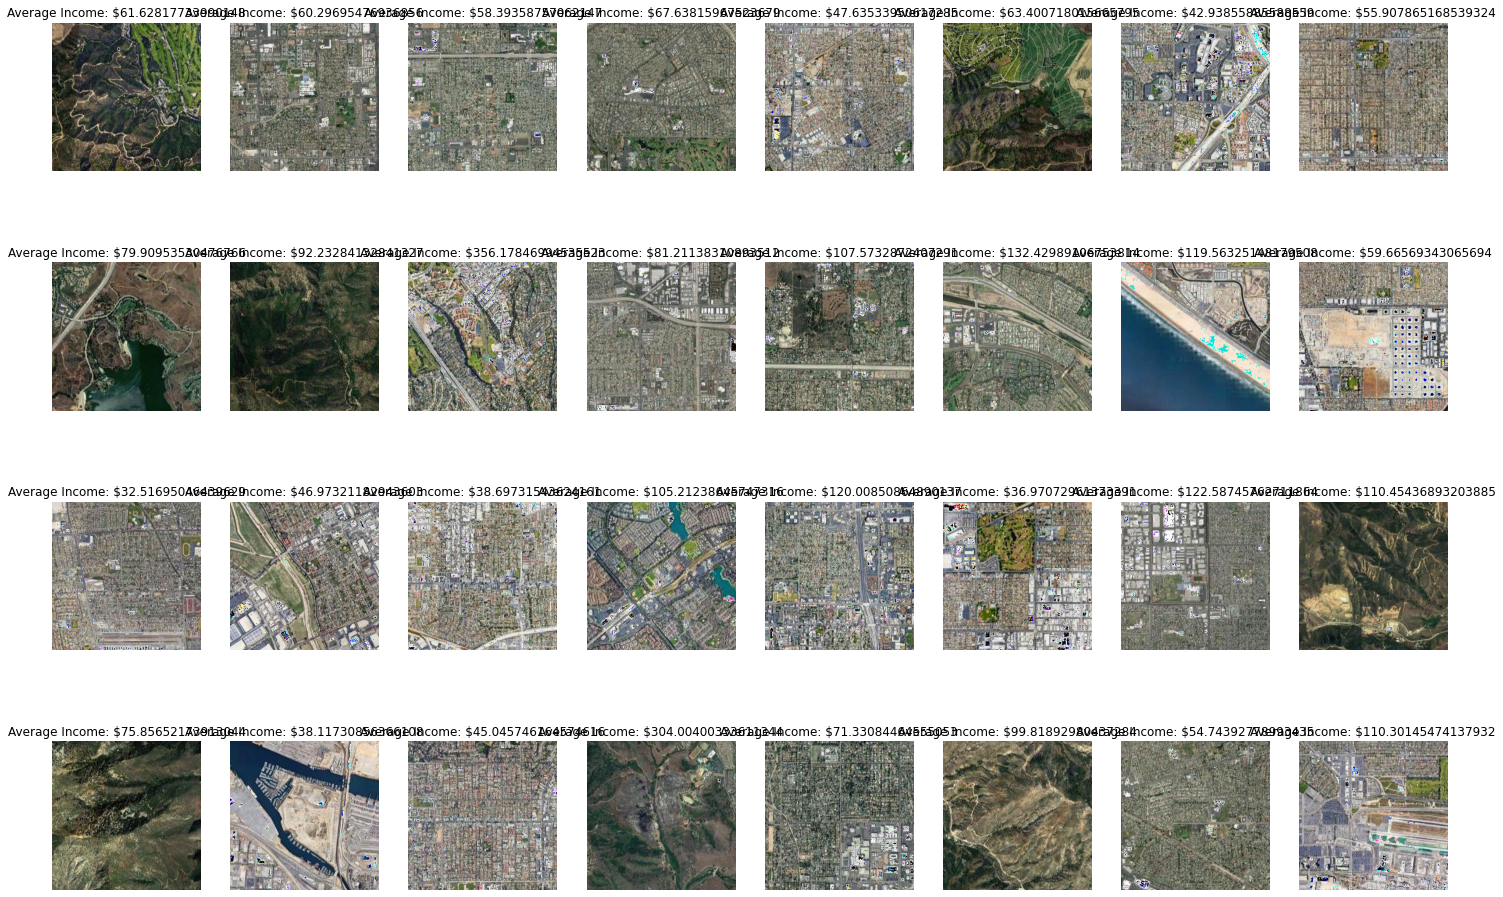

In [106]:
figure = plt.figure(figsize=(25, 10))
plt.subplots_adjust(top=1.4)
num_rows = 4
num_cols = 8
for idx in range(batch_size):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title('Average Income: ${}'.format(labels[idx]))
  image = np.moveaxis(images[idx].numpy(), 0, -1)
  image = (image * 275).astype(np.uint8)
  plt.imshow(image)

In [107]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalNeuralNet(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNet, self).__init__()
    self.pool = nn.MaxPool2d(3, 2)

    self.conv1 = nn.Conv2d(3, 96, 5, padding=2)
    self.conv2 = nn.Conv2d(96, 96, 5, stride=2, padding=2)
    self.conv3 = nn.Conv2d(96, 96, 5, padding=2)

    # output of x.shape prior to calling fc1
    self.fc1 = nn.Linear(96 * 15 * 15, 500)
    self.fc2 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)

    #print(x.shape)
    x = x.view(-1, 96 * 15 * 15)
    x = F.dropout(x)
    x = F.relu(self.fc1(x))
    x = F.dropout(x)
    x = self.fc2(x)
    return x

In [110]:
cnn_model = ConvolutionalNeuralNet().to(device=device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.001) 
#criterion = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(cnn_model.parameters(), lr = 0.01, momentum=0.9)


epoch_losses = []

for epoch in range(100):
  epoch_loss = 0
  for batch_idx, (images, labels) in enumerate(trainloader):
    # Load the images and labels on the GPU
    images = images.to(device=device)
    labels = labels.to(device=device)
    
    optimizer.zero_grad()                 # resets the information from last time
    pred_labels = cnn_model(images).squeeze()       # calculates the predictions
    loss = criterion(pred_labels, labels) # calculates the loss
    loss.backward()                       # gradient descent, part 1
    torch.nn.utils.clip_grad_norm(cnn_model.parameters(), 10) #uncomment if needed
    optimizer.step()                      # gradient descent, part 2

    epoch_loss += loss.item() / labels.shape[0]
    if batch_idx % 10 == 0:
      print(f"Epoch {epoch}, batch {batch_idx}: {loss}")
  epoch_losses.append(epoch_loss)

  print(f"Epoch {epoch}: {epoch_loss}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 0, batch 0: 139.24799486510238
Epoch 0, batch 10: 74.73345354518145
Epoch 0, batch 20: 53.85405941184339
Epoch 0, batch 30: 43.50255618037441
Epoch 0: 70.74737477778008
Epoch 1, batch 0: 70.44086004918863
Epoch 1, batch 10: 70.50848271859245
Epoch 1, batch 20: 42.91556632379021
Epoch 1, batch 30: 65.21271369024245
Epoch 1: 64.48649541719512
Epoch 2, batch 0: 45.731672695607145
Epoch 2, batch 10: 79.195277483357
Epoch 2, batch 20: 48.6346680051885
Epoch 2, batch 30: 66.81559376754947
Epoch 2: 61.823906382619725
Epoch 3, batch 0: 55.62252480345116
Epoch 3, batch 10: 59.31802363357899
Epoch 3, batch 20: 31.745002870949023
Epoch 3, batch 30: 65.74941526889316
Epoch 3: 59.85714028692071
Epoch 4, batch 0: 55.712671006470046
Epoch 4, batch 10: 52.94173674452984
Epoch 4, batch 20: 60.4935548850224
Epoch 4, batch 30: 83.26291875089873
Epoch 4: 64.32099874930879
Epoch 5, batch 0: 52.72673315526204
Epoch 5, batch 10: 72.68987117560091
Epoch 5, batch 20: 47.99407005994047
Epoch 5, batch 30: 

KeyboardInterrupt: ignored

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for images, labels in testloader:
    outputs = cnn_model(images.to(device=device))
    predicted = outputs.data.cpu()
    total += labels.size(0)
    correct += (1 - abs(predicted - labels)/labels).sum().item()
    #correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')

KeyboardInterrupt: ignored

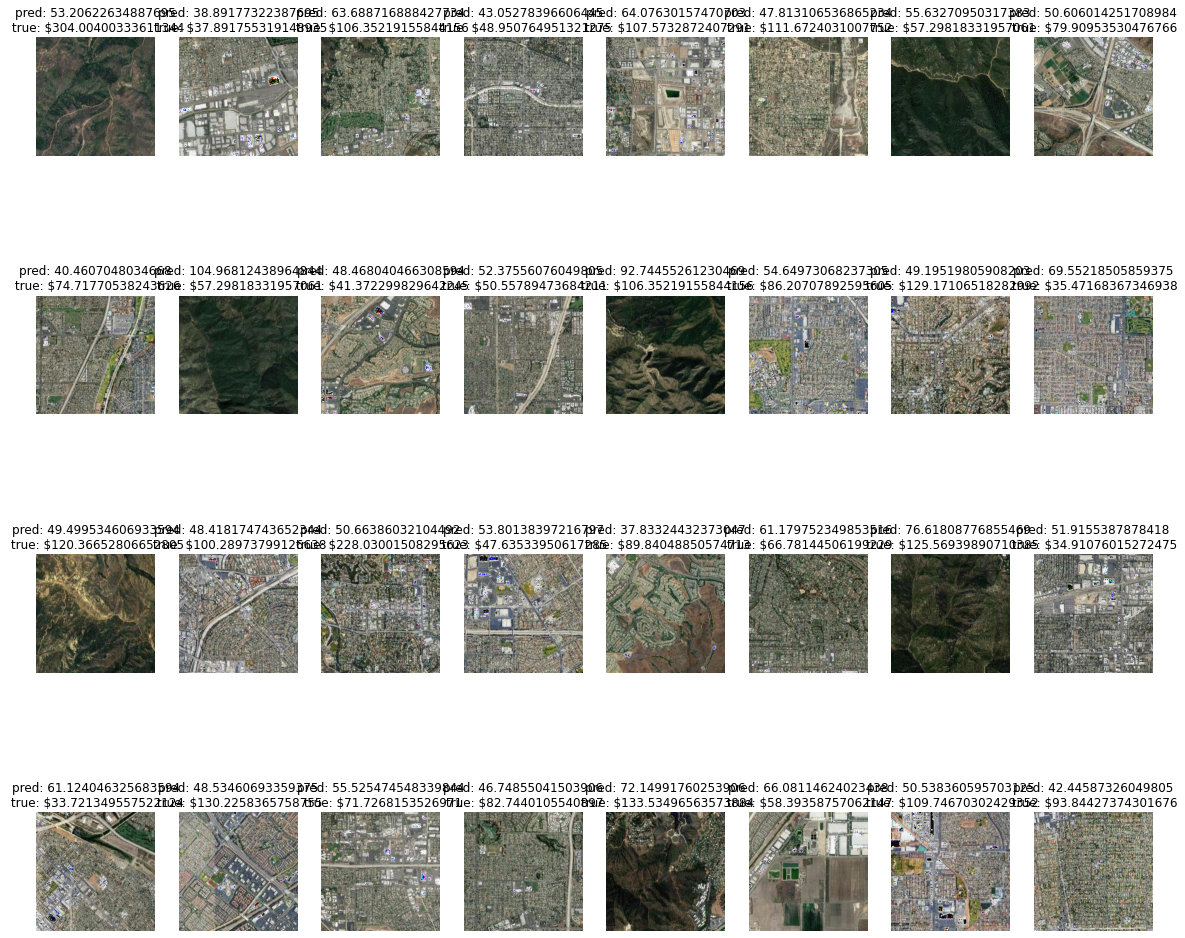

In [109]:
images, labels = next(iter(testloader))
cnn_model.eval()
outputs = cnn_model(images.to(device=device))
predicted = outputs.data.cpu().numpy().squeeze()

figure = plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.5)
num_rows = 4
num_cols = 8
for idx in range(batch_size):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title(f"pred: {predicted[idx]}\n true: ${labels[idx]}")
  image = np.moveaxis(images[idx].numpy(), 0, -1)
  image = (image * 275).astype(np.uint8)
  plt.imshow(image)